# Random Forest regressor

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor


from statsmodels.tools.eval_measures import stde




## Read the etl info results

In [2]:
df_info = pd.read_csv('../dataset_clean/options_csv_v1_etl.csv')
df_info

,remove_time_features,generic_features,remove_atypical_values,feature_combination,remove_feature_selection,remove_invalid_correlated_features
0,False,False,False,False,False,False


## Read the dataset

In [3]:
df = pd.read_csv('../dataset/V2_PlatteRiverWeir_features_merged_all.csv')
df

,Unnamed: 0.1,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,...,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma,RiverArea,RiverWidth
0,0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,statelineweir_20120609_farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,49975.0,207.508733
1,1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,statelineweir_20120609_farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,50184.0,208.663145
2,2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,statelineweir_20120609_farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,50543.0,209.445067
3,3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,statelineweir_20120609_farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,50856.0,211.265690
4,4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,statelineweir_20120609_farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,51004.0,211.250274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42054,42054,42054,2019-10-11 09:00:00,2019-10-11T08:59:53,statelineweir_20191011_farrell_409.jpg,USGS,6674500,MDT,2.54,434.0,...,9284.0,77521.0,38385.370066,15952.029728,0.0,70085.0,37550.894823,16444.401209,45842.0,194.934605
42055,42055,42055,2019-10-11 10:00:00,2019-10-11T09:59:52,statelineweir_20191011_farrell_410.jpg,USGS,6674500,MDT,2.54,434.0,...,10092.0,74614.0,40162.989292,15467.708856,0.0,70061.0,39397.339095,16009.008049,42300.0,194.762264
42056,42056,42056,2019-10-11 11:00:00,2019-10-11T10:59:52,statelineweir_20191011_farrell_411.jpg,USGS,6674500,MDT,2.54,434.0,...,7067.0,83260.0,42095.946590,16770.357949,0.0,76335.0,41350.006568,17489.374617,41080.0,196.480105
42057,42057,42057,2019-10-11 12:00:00,2019-10-11T11:59:53,statelineweir_20191011_farrell_412.jpg,USGS,6674500,MDT,2.54,434.0,...,6283.0,83045.0,45345.490954,17498.432849,0.0,78882.0,44553.920296,18268.294896,40976.0,193.595245


In [4]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year
df['Month'] = df['SensorTime'].dt.month

In [5]:
df.dtypes

Unnamed: 0.1                 int64
Unnamed: 0                   int64
SensorTime          datetime64[ns]
CaptureTime                 object
Filename                    object
                         ...      
WwCurveLineSigma           float64
RiverArea                  float64
RiverWidth                 float64
Year                         int64
Month                        int64
Length: 65, dtype: object

In [6]:
df = df[df.Stage > 0]
df = df[df.Discharge > 0]

In [7]:

df.isna().sum()

Unnamed: 0.1        0
Unnamed: 0          0
SensorTime          0
CaptureTime         0
Filename            0
                   ..
WwCurveLineSigma    0
RiverArea           0
RiverWidth          0
Year                0
Month               0
Length: 65, dtype: int64

## Divide dataset to X and Y

In [8]:
df_train = df[(df.Year >= 2012) & (df.Year <= 2017)]
#df_val = df[(df.Year >= 2017) & (df.Year <= 2017)]
df_test = df[(df.Year >= 2018) & (df.Year <= 2019)]

In [9]:
df_train = df_train.drop(columns=["Year", "SensorTime", "CaptureTime"])
#df_val = df_val.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_test = df_test.drop(columns=["Year", "SensorTime", "CaptureTime"])

In [10]:
np.random.seed(0)

y_train = df_train[["Stage"]]
X_train = df_train[["RiverWidth", "Month"]]

temp = list(zip(X_train.values, y_train.values))
np.random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train, y_train = np.array(X_train), np.array(y_train)


y_test = df_test[["Stage"]].values
X_test = df_test[["RiverWidth", "Month"]].values

"""temp = list(zip(X_test.values, y_test.values))
np.random.shuffle(temp)
X_test, y_test = zip(*temp)
X_test, y_test = np.array(X_test), np.array(y_test)"""

'temp = list(zip(X_test.values, y_test.values))\nnp.random.shuffle(temp)\nX_test, y_test = zip(*temp)\nX_test, y_test = np.array(X_test), np.array(y_test)'

In [11]:
print(X_train.shape)
print(y_train.shape)

(27421, 2)
(27421, 1)


In [12]:
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]

print(input_shape, output_shape)

2 1


## Train model

In [15]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestRegressor(random_state=0))
])

#param_grid = {'clf__hidden_layer_sizes': [(10), (10, 20), (10, 5, 15), (20, 30, 10, 15)], 'clf__alpha': np.arange(1e-3, 1, 0.001), 'clf__learning_rate_init': np.arange(1e-3, 0.1, 0.001), 'clf__activation': ['tanh', 'relu']}

param_grid = { 'clf__n_estimators': np.arange(50, 200, 1)}

clf = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=40, n_jobs=8, verbose=3, scoring="neg_mean_squared_error")

In [16]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pip

[CV 2/5] END ............clf__n_estimators=110;, score=-0.354 total time=   2.7s
[CV 3/5] END ............clf__n_estimators=110;, score=-0.362 total time=   2.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END ............clf__n_estimators=110;, score=-0.340 total time=   3.2s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END ............clf__n_estimators=174;, score=-0.337 total time=   4.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END ............clf__n_estimators=174;, score=-0.339 total time=   4.5s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END ............clf__n_estimators=174;, score=-0.349 total time=   4.8s
[CV 2/5] END ............clf__n_estimators=174;, score=-0.354 total time=   5.1s
[CV 3/5] END ............clf__n_estimators=174;, score=-0.362 total time=   5.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END .............clf__n_estimators=84;, score=-0.341 total time=   2.5s
[CV 4/5] END ............clf__n_estimators=110;, score=-0.349 total time=   3.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END ............clf__n_estimators=110;, score=-0.338 total time=   3.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END .............clf__n_estimators=84;, score=-0.354 total time=   2.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END .............clf__n_estimators=84;, score=-0.362 total time=   2.5s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END .............clf__n_estimators=84;, score=-0.348 total time=   2.5s
[CV 5/5] END .............clf__n_estimators=84;, score=-0.339 total time=   2.5s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END ............clf__n_estimators=176;, score=-0.339 total time=   4.6s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END ............clf__n_estimators=176;, score=-0.354 total time=   4.4s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END ............clf__n_estimators=176;, score=-0.362 total time=   4.7s
[CV 4/5] END ............clf__n_estimators=176;, score=-0.349 total time=   4.5s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END ............clf__n_estimators=141;, score=-0.340 total time=   3.9s
[CV 5/5] END ............clf__n_estimators=176;, score=-0.337 total time=   4.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END ............clf__n_estimators=141;, score=-0.354 total time=   4.2s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END ............clf__n_estimators=141;, score=-0.362 total time=   4.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END ............clf__n_estimators=141;, score=-0.338 total time=   3.5s
[CV 4/5] END ............clf__n_estimators=141;, score=-0.349 total time=   4.1s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END .............clf__n_estimators=83;, score=-0.341 total time=   2.4s
[CV 1/5] END ............clf__n_estimators=149;, score=-0.340 total time=   3.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END ............clf__n_estimators=149;, score=-0.362 total time=   3.8s
[CV 2/5] END ............clf__n_estimators=149;, score=-0.354 total time=   4.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END ............clf__n_estimators=149;, score=-0.338 total time=   3.7s
[CV 4/5] END ............clf__n_estimators=149;, score=-0.349 total time=   4.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END .............clf__n_estimators=83;, score=-0.354 total time=   2.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END .............clf__n_estimators=83;, score=-0.362 total time=   2.5s
[CV 5/5] END .............clf__n_estimators=83;, score=-0.339 total time=   2.1s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END .............clf__n_estimators=83;, score=-0.348 total time=   2.3s
[CV 1/5] END .............clf__n_estimators=72;, score=-0.341 total time=   2.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END .............clf__n_estimators=72;, score=-0.355 total time=   2.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END .............clf__n_estimators=72;, score=-0.349 total time=   1.9s
[CV 3/5] END .............clf__n_estimators=72;, score=-0.362 total time=   2.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END .............clf__n_estimators=72;, score=-0.339 total time=   2.1s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END .............clf__n_estimators=81;, score=-0.362 total time=   1.9s
[CV 1/5] END .............clf__n_estimators=81;, score=-0.341 total time=   2.2s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END .............clf__n_estimators=81;, score=-0.354 total time=   2.4s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END .............clf__n_estimators=81;, score=-0.349 total time=   2.2s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END .............clf__n_estimators=76;, score=-0.341 total time=   2.0s
[CV 5/5] END .............clf__n_estimators=81;, score=-0.339 total time=   2.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END .............clf__n_estimators=76;, score=-0.355 total time=   2.2s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END .............clf__n_estimators=76;, score=-0.349 total time=   1.9s
[CV 3/5] END .............clf__n_estimators=76;, score=-0.362 total time=   2.2s
[CV 5/5] END .............clf__n_estimators=76;, score=-0.339 total time=   2.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END ............clf__n_estimators=129;, score=-0.340 total time=   3.8s
[CV 2/5] END ............clf__n_estimators=129;, score=-0.354 total time=   3.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END ............clf__n_estimators=129;, score=-0.362 total time=   3.5s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END ............clf__n_estimators=129;, score=-0.349 total time=   3.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END ............clf__n_estimators=129;, score=-0.338 total time=   3.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END ............clf__n_estimators=125;, score=-0.340 total time=   3.2s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END ............clf__n_estimators=125;, score=-0.362 total time=   3.5s
[CV 1/5] END .............clf__n_estimators=55;, score=-0.341 total time=   1.3s
[CV 2/5] END ............clf__n_estimators=125;, score=-0.354 total time=   3.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END .............clf__n_estimators=55;, score=-0.355 total time=   1.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END .............clf__n_estimators=55;, score=-0.363 total time=   1.6s
[CV 4/5] END .............clf__n_estimators=55;, score=-0.351 total time=   1.4s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END .............clf__n_estimators=55;, score=-0.340 total time=   1.6s
[CV 5/5] END ............clf__n_estimators=125;, score=-0.338 total time=   3.1s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END ............clf__n_estimators=125;, score=-0.349 total time=   3.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END ............clf__n_estimators=136;, score=-0.340 total time=   3.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END ............clf__n_estimators=136;, score=-0.354 total time=   3.9s
[CV 3/5] END ............clf__n_estimators=136;, score=-0.362 total time=   3.8s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END ............clf__n_estimators=136;, score=-0.349 total time=   4.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END ............clf__n_estimators=136;, score=-0.338 total time=   4.1s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END ............clf__n_estimators=166;, score=-0.339 total time=   4.9s
[CV 2/5] END ............clf__n_estimators=166;, score=-0.354 total time=   4.9s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END ............clf__n_estimators=166;, score=-0.362 total time=   4.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END ............clf__n_estimators=106;, score=-0.340 total time=   3.2s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END ............clf__n_estimators=106;, score=-0.354 total time=   3.2s
[CV 3/5] END ............clf__n_estimators=106;, score=-0.362 total time=   3.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END ............clf__n_estimators=166;, score=-0.349 total time=   4.7s
[CV 5/5] END ............clf__n_estimators=166;, score=-0.338 total time=   4.6s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END ............clf__n_estimators=106;, score=-0.349 total time=   3.1s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END ............clf__n_estimators=106;, score=-0.338 total time=   3.2s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END .............clf__n_estimators=71;, score=-0.342 total time=   2.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END .............clf__n_estimators=71;, score=-0.355 total time=   2.1s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END .............clf__n_estimators=71;, score=-0.362 total time=   2.1s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END ............clf__n_estimators=196;, score=-0.339 total time=   5.7s
[CV 4/5] END .............clf__n_estimators=71;, score=-0.349 total time=   2.1s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END ............clf__n_estimators=196;, score=-0.355 total time=   5.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END ............clf__n_estimators=196;, score=-0.349 total time=   5.8s
[CV 5/5] END .............clf__n_estimators=71;, score=-0.340 total time=   2.1s
[CV 3/5] END ............clf__n_estimators=196;, score=-0.361 total time=   5.9s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END ............clf__n_estimators=196;, score=-0.337 total time=   5.9s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END ............clf__n_estimators=139;, score=-0.340 total time=   4.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END ............clf__n_estimators=139;, score=-0.354 total time=   4.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END ............clf__n_estimators=139;, score=-0.362 total time=   4.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END ............clf__n_estimators=139;, score=-0.349 total time=   4.1s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END ............clf__n_estimators=139;, score=-0.338 total time=   4.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END ............clf__n_estimators=181;, score=-0.354 total time=   5.4s
[CV 1/5] END ............clf__n_estimators=181;, score=-0.339 total time=   5.5s
[CV 1/5] END .............clf__n_estimators=82;, score=-0.341 total time=   2.4s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END .............clf__n_estimators=82;, score=-0.354 total time=   2.4s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END ............clf__n_estimators=181;, score=-0.362 total time=   5.5s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END .............clf__n_estimators=82;, score=-0.362 total time=   2.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END .............clf__n_estimators=82;, score=-0.339 total time=   2.4s
[CV 4/5] END ............clf__n_estimators=181;, score=-0.349 total time=   5.9s
[CV 4/5] END .............clf__n_estimators=82;, score=-0.349 total time=   2.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END ............clf__n_estimators=181;, score=-0.337 total time=   5.9s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END .............clf__n_estimators=54;, score=-0.341 total time=   1.8s
[CV 2/5] END .............clf__n_estimators=54;, score=-0.355 total time=   1.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END .............clf__n_estimators=54;, score=-0.363 total time=   1.6s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END ............clf__n_estimators=168;, score=-0.355 total time=   5.1s
[CV 1/5] END ............clf__n_estimators=168;, score=-0.340 total time=   5.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END ............clf__n_estimators=168;, score=-0.362 total time=   5.2s
[CV 5/5] END .............clf__n_estimators=54;, score=-0.340 total time=   1.5s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END ............clf__n_estimators=168;, score=-0.349 total time=   5.1s
[CV 4/5] END .............clf__n_estimators=54;, score=-0.351 total time=   1.8s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END .............clf__n_estimators=56;, score=-0.341 total time=   1.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END .............clf__n_estimators=56;, score=-0.355 total time=   1.7s
[CV 3/5] END .............clf__n_estimators=56;, score=-0.363 total time=   1.6s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END ............clf__n_estimators=168;, score=-0.338 total time=   4.8s
[CV 4/5] END .............clf__n_estimators=56;, score=-0.351 total time=   1.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END .............clf__n_estimators=56;, score=-0.340 total time=   1.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END ............clf__n_estimators=191;, score=-0.354 total time=   5.4s
[CV 1/5] END ............clf__n_estimators=191;, score=-0.339 total time=   5.5s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END ............clf__n_estimators=191;, score=-0.361 total time=   5.3s
[CV 2/5] END ............clf__n_estimators=156;, score=-0.354 total time=   4.4s
[CV 1/5] END ............clf__n_estimators=156;, score=-0.340 total time=   4.6s
[CV 4/5] END ............clf__n_estimators=191;, score=-0.349 total time=   5.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pip

[CV 3/5] END ............clf__n_estimators=156;, score=-0.362 total time=   4.5s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END ............clf__n_estimators=191;, score=-0.337 total time=   5.4s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END .............clf__n_estimators=63;, score=-0.355 total time=   1.8s
[CV 1/5] END .............clf__n_estimators=63;, score=-0.342 total time=   1.9s
[CV 4/5] END .............clf__n_estimators=63;, score=-0.350 total time=   1.7s
[CV 3/5] END .............clf__n_estimators=63;, score=-0.362 total time=   1.9s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pip

[CV 5/5] END .............clf__n_estimators=63;, score=-0.340 total time=   1.9s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END .............clf__n_estimators=80;, score=-0.341 total time=   2.4s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END .............clf__n_estimators=80;, score=-0.362 total time=   2.1s
[CV 2/5] END .............clf__n_estimators=80;, score=-0.354 total time=   2.3s
[CV 5/5] END ............clf__n_estimators=156;, score=-0.338 total time=   4.4s
[CV 4/5] END .............clf__n_estimators=80;, score=-0.349 total time=   2.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pip

[CV 4/5] END ............clf__n_estimators=156;, score=-0.349 total time=   4.7s
[CV 5/5] END .............clf__n_estimators=80;, score=-0.339 total time=   2.4s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END .............clf__n_estimators=99;, score=-0.340 total time=   2.8s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END .............clf__n_estimators=99;, score=-0.353 total time=   2.9s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END .............clf__n_estimators=99;, score=-0.362 total time=   2.6s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END .............clf__n_estimators=99;, score=-0.338 total time=   2.9s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END .............clf__n_estimators=99;, score=-0.349 total time=   3.1s
[CV 3/5] END ............clf__n_estimators=109;, score=-0.362 total time=   2.9s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END ............clf__n_estimators=109;, score=-0.354 total time=   3.1s
[CV 1/5] END ............clf__n_estimators=109;, score=-0.340 total time=   3.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END ............clf__n_estimators=109;, score=-0.349 total time=   3.1s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END .............clf__n_estimators=59;, score=-0.342 total time=   1.6s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END .............clf__n_estimators=59;, score=-0.355 total time=   1.7s
[CV 4/5] END .............clf__n_estimators=59;, score=-0.350 total time=   1.6s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END ............clf__n_estimators=109;, score=-0.338 total time=   3.1s
[CV 3/5] END .............clf__n_estimators=59;, score=-0.363 total time=   1.8s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END .............clf__n_estimators=59;, score=-0.340 total time=   1.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END .............clf__n_estimators=73;, score=-0.341 total time=   2.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END .............clf__n_estimators=73;, score=-0.355 total time=   2.0s
[CV 3/5] END .............clf__n_estimators=73;, score=-0.362 total time=   1.9s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END .............clf__n_estimators=73;, score=-0.349 total time=   2.0s
[CV 5/5] END .............clf__n_estimators=73;, score=-0.339 total time=   1.9s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END .............clf__n_estimators=89;, score=-0.340 total time=   2.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END .............clf__n_estimators=89;, score=-0.362 total time=   2.3s
[CV 2/5] END .............clf__n_estimators=89;, score=-0.354 total time=   2.5s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END ............clf__n_estimators=195;, score=-0.339 total time=   5.5s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END ............clf__n_estimators=195;, score=-0.355 total time=   5.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END ............clf__n_estimators=195;, score=-0.361 total time=   5.8s
[CV 4/5] END .............clf__n_estimators=89;, score=-0.348 total time=   2.6s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END ............clf__n_estimators=195;, score=-0.349 total time=   5.8s
[CV 5/5] END ............clf__n_estimators=195;, score=-0.337 total time=   5.6s
[CV 5/5] END .............clf__n_estimators=89;, score=-0.339 total time=   2.5s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END ............clf__n_estimators=169;, score=-0.340 total time=   5.0s
[CV 1/5] END .............clf__n_estimators=98;, score=-0.340 total time=   2.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END .............clf__n_estimators=98;, score=-0.354 total time=   2.9s
[CV 3/5] END .............clf__n_estimators=98;, score=-0.362 total time=   3.1s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END ............clf__n_estimators=169;, score=-0.355 total time=   4.9s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END ............clf__n_estimators=169;, score=-0.362 total time=   5.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END ............clf__n_estimators=169;, score=-0.337 total time=   4.9s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END ............clf__n_estimators=169;, score=-0.349 total time=   5.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END .............clf__n_estimators=98;, score=-0.338 total time=   2.8s
[CV 4/5] END .............clf__n_estimators=98;, score=-0.349 total time=   3.0s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END ............clf__n_estimators=147;, score=-0.354 total time=   4.3s
[CV 1/5] END ............clf__n_estimators=147;, score=-0.340 total time=   4.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END ............clf__n_estimators=147;, score=-0.362 total time=   4.3s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END ............clf__n_estimators=128;, score=-0.340 total time=   3.9s
[CV 5/5] END ............clf__n_estimators=147;, score=-0.338 total time=   4.2s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END ............clf__n_estimators=147;, score=-0.349 total time=   4.6s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END ............clf__n_estimators=128;, score=-0.354 total time=   3.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END ............clf__n_estimators=128;, score=-0.362 total time=   3.8s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END ............clf__n_estimators=128;, score=-0.349 total time=   4.0s
[CV 5/5] END ............clf__n_estimators=128;, score=-0.338 total time=   3.9s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END ............clf__n_estimators=177;, score=-0.339 total time=   5.1s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END ............clf__n_estimators=177;, score=-0.354 total time=   5.1s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END ............clf__n_estimators=177;, score=-0.349 total time=   5.2s
[CV 3/5] END ............clf__n_estimators=177;, score=-0.362 total time=   5.4s
[CV 5/5] END ............clf__n_estimators=177;, score=-0.337 total time=   5.4s
[CV 1/5] END ............clf__n_estimators=198;, score=-0.339 total time=   5.8s
[CV 2/5] END ............clf__n_estimators=198;, score=-0.355 total time=   5.2s
[CV 3/5] END ............clf__n_estimators=198;, score=-0.361 total time=   5.4s
[CV 4/5] END ............clf__n_estimators=198;, score=-0.349 total time=   4.8s
[CV 5/5] END ............clf__n_estimators=198;, score=-0.337 total time=   4.7s


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf',
                                              RandomForestRegressor(random_state=0))]),
                   n_iter=40, n_jobs=8,
                   param_distributions={'clf__n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102,...
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199])},
                   scoring='neg_mean_squared_error', verbose=3)

## Test model

In [17]:
clf.best_score_

-0.34818562079085413

In [18]:
clf.best_params_

{'clf__n_estimators': 191}

In [19]:
clf.score(X_test, y_test)

-0.3910314178933432

In [20]:
y_pred = clf.predict(X_test)

In [21]:
print("R^2: ", r2_score(y_test, y_pred))
print("mse: ", mean_squared_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("mape: ", mean_absolute_percentage_error(y_test, y_pred))
print("Error estandar: ", stde(y_test.squeeze(),
      y_pred.squeeze(), ddof=2))


R^2:  -0.0012609766539810607
mse:  0.3910314178933432
rmse:  0.6253250497887824
mae:  0.4154720318115519
mape:  0.1513670752013252
Error estandar:  0.5792532101546731


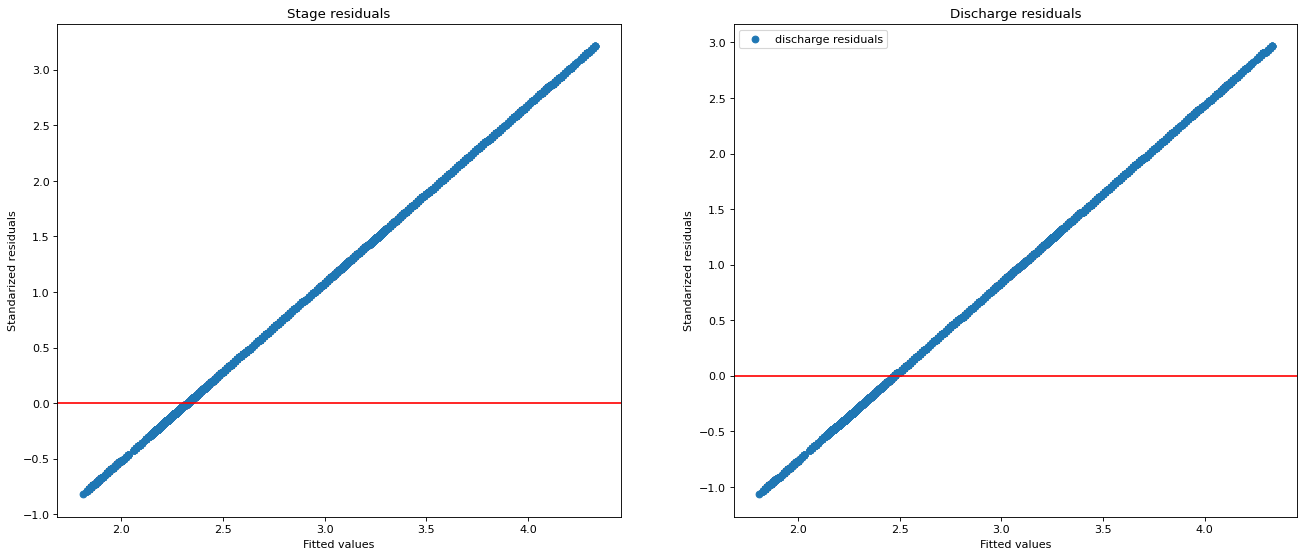

In [22]:
residuals = y_test - y_pred
residuals_std = residuals/residuals.std()

y_real_stage = np.array([i[0] for i in y_test])
residual_stage = np.array([i[0] for i in residuals])

y_real_discharge = np.array([i[-1] for i in y_test])
residual_discharge = np.array([i[-1] for i in residuals])


figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
ax[1].scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
ax[0].axhline(y=0.0, color='r', linestyle='-')
ax[1].axhline(y=0.0, color='r', linestyle='-')

ax[0].set_title("Stage residuals")
ax[1].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()

In [23]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad

#figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')
plt.show()

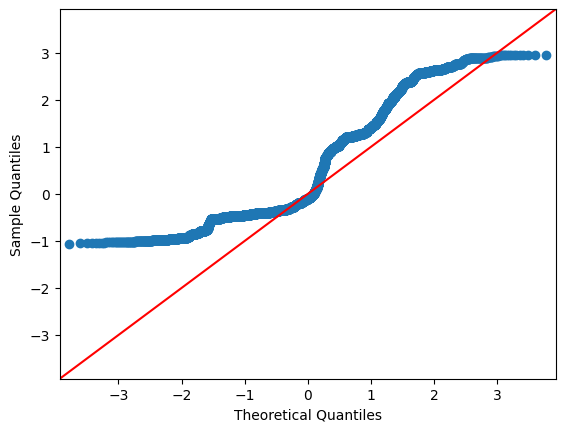

In [24]:
figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')
plt.show()

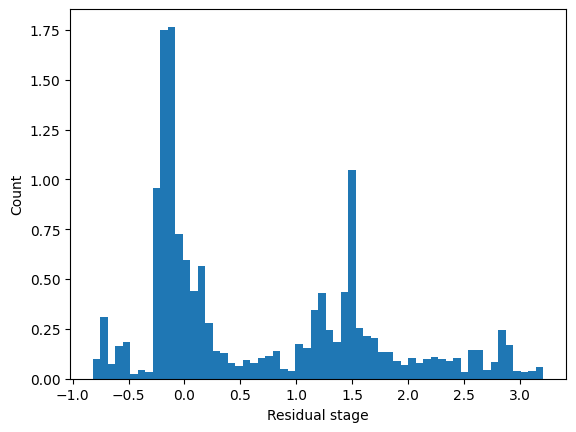

In [25]:
plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual stage');
plt.show()

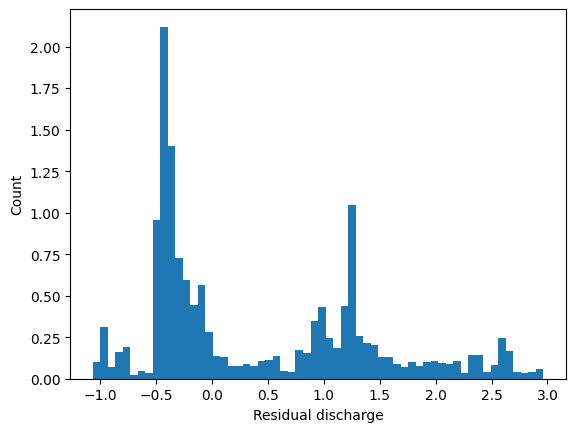

In [26]:
plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()

In [27]:
stat, pval = normal_ad(residual_discharge / residual_discharge.std())
print("p-value:", pval)

if pval < 0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")


p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


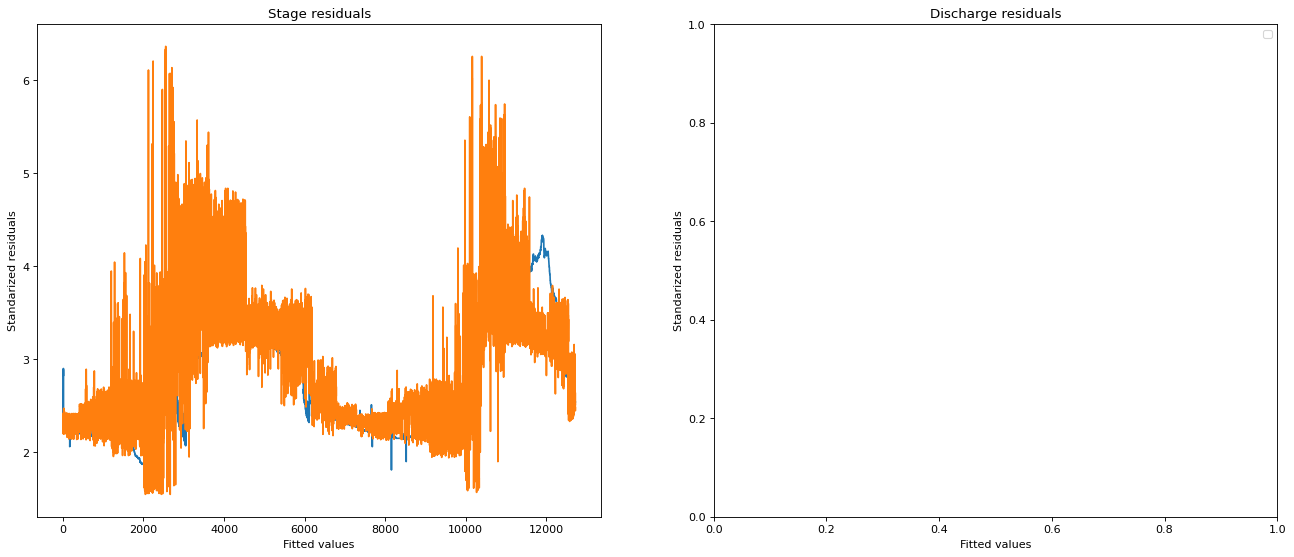

In [28]:
figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].plot(np.arange(len(y_test)), y_test, label="Stage real")
ax[0].plot(np.arange(len(y_test)), y_pred, label="Stage pred")

ax[0].set_title("Stage residuals")
ax[1].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()